# 计算物理第九次作业
姓名：王兴未 学号：2018302020138 班级：18级3班

In [2]:
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


**5.2** Use the symmetry of the problem described in Figure 5.4 to write a program that solves for $V$ by calculating the potential in only half of one quadrant of the $x-y$ plane.

## Problem 5.2

其初始问题是这样一个二维问题（虽然是三维的，但是可以认为在z方向上距离为无穷大，从而在z方向的分布总是均匀的，对总体分布无影响）：在一块边长为2的正方形导体边界上的电势$V = 10$,而电势在无穷远点处的值$V = 0$.且对于电磁场来说，其电势分布满足$Laplace\;Equation$:

$$\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0$$

我们使用$relaxation\; method$，其原理如下：

首先，对于函数$V(i,j)$,其对x的偏导数可写为：

$$\frac{\partial V}{\partial x} \approx \frac{V(i,j)\, -\, V(i-1,j)}{\Delta x}$$

当然，也可以写成：

$$\frac{\partial V}{\partial x} \approx \frac{V(i+1,j)\, -\, V(i-1,j)}{2\Delta x}$$

那么，二阶导数就可以写为：

$$\frac{\partial^2 V}{\partial x^2} \approx \frac{1}{\Delta x} \left[ \left. \frac{\partial V}{\partial x} \right|_{x=i+\frac{1}{2}} - \left. \frac{\partial V}{\partial x} \right|_{x=i-\frac{1}{2}} \right]$$
也即：
$$\frac{\partial^2 V}{\partial x^2} \approx \frac{1}{\Delta x} \left[ \frac{V(i+1,j)-V(i,j)}{\Delta x} - \frac{V(i,j)-V(i - 1,j)}{\Delta x} \right]$$

$$\frac{\partial^2 V}{\partial x^2} \approx \frac{V(i+1,j) + V(i-1,j) - 2V(i,j)}{\Delta x^2}$$

对于y，其二阶偏导数可写为类似的形式。代入$Laplace\;Equation$并取$\Delta x = \Delta y$，通过化简最终可得：

$$V(i,j)=\frac{1}{4}[V(i+1,j)+V(i-1,j)+V(i,j+1)+V(i,j-1)]$$

开始时，除边界外的其他点，我们假设一个解$V_0(i,j)$,随后利用上式进行迭代获得$V_1(i,j)$，如此循环往复，直至获得的$V_n(i,j)$符合收敛要求。

对于此题，边界条件为$V = 10, \; x = \pm 1, y = \pm 1$，另一条件本为无穷远处电势为0，为使得问题可以计算，我们取$V = 0, \; x = \pm 5, y = \pm 5$，并取$V_0(i,j) = 0, \forall (i.j)$，收敛条件为$\Delta V \leq 1 \times 10^{-5} per\, site$，取点间隔为$\Delta x = \Delta y = 0.2$，此时共会取得49^2 = 2401个内点及200个边界点。

同时，由于所考虑区域的轴对称性以及旋转对称性，所考虑问题可由1/8个区域的结果旋转而成。因此，我们可以简化涉及到的点数数量。

在这种情况下，$y = x, -5 \leq x \leq 0$及$x = 0, -5 \leq y \leq 0$从内点变为了边界点。这些区域上的点并没有周围的四个点对其进行作用。但以$x = 0, -5 \leq y \leq 0$上的点为例，其右侧的点缺失，但由于对称性，左侧的点与右侧的点值相等。因此，可以利用左侧的对应点的作用乘以2来计算其值。另一条直线上的处理方法是类似的。

我们尝试利用numpy的二维数组来构建这样一个三角型数组，然后用mayavi的surf()函数作图。

In [3]:
from mayavi import mlab
import matplotlib.pyplot as plt
import numpy as np

def relaxation(V_old, V_new):
    for i in range(6, 25):
        for j in range(25 - i, 26):
            if(i + j != 25 and j != 25):
                V_new[i, j] = 0.25 * (V_old[i + 1, j] + V_old[i - 1, j] + V_old[i, j + 1] + V_old[i, j - 1])
            elif(j == 25):
                V_new[i, j] = 0.25 * (V_old[i - 1, j] + V_old[i + 1, j] +  2 * V_old[i, j - 1])
            else:
                V_new[i, j] = 0.5 * (V_old[i + 1, j] + V_old[i, j + 1])
    return V_new

def cal_dV(V_old, V_new):
    dV = 0
    for i in range(6, 25):
        for j in range(25 - i, 25):
            dV += np.abs(V_new[i, j] - V_old[i, j])
    return dV

V1 = np.zeros((26,26))
V2 = np.zeros((26,26))
V1[0:7, 19:26] = 10
V2[0:7, 19:26] = 10
i = 0

#Compute the 1/8 plate
while(True):
    relaxation(V1, V2)
    relaxation(V2, V1)
    i += 1
    dV = cal_dV(V2, V1)
    if(i > 20):
        if(dV < 1e-3):
            break
#Compute end
V_middle = V1.copy()
#Paste the result into the other 7 areas
for i in range(26):
    for j in range(26):
        if(i + j < 26):
            V1[i, j] = V1[25 - j, 25 - i]
        else:
            pass

V_lt = np.zeros((26,26))
V_rt = np.zeros((26,26))
V_rb = np.zeros((26,26)) #lt repersents left-top, and rb represents right-bottom.

for i in range(26):
    for j in range(26):
        V_lt[i, j] = V1[25 - i, j]
        V_rb[i, j] = V1[i, 25 - j]
        V_rt[i, j] = V1[25 - i, 25 - j]

V_l = np.concatenate((V_lt, V1))
V_r = np.concatenate((V_rt, V_rb))
V = np.concatenate((V_l, V_r), axis = 1)

mlab.clf()
mlab.surf(V, warp_scale = 'auto')
mlab.axes(ranges = [-5, 5, -5, 5, 0, 10], xlabel='x', ylabel='y', zlabel='V')
mlab.outline()
mlab.contour_surf(V, contours = [2], color = (1, 0, 0))
mlab.colorbar()
mlab.title('The potential field of a square mental plate with charges')


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

其结果为：
![Potential.jpg](./Potential_2.png)
其中在腰部的一条红色环线代表V = 2的等势线。

对应的1/8平面的计算结果为：
![Potential_1_8.png](./Potential_1_8.jpg)

并且，我们可以做出等势线如下图

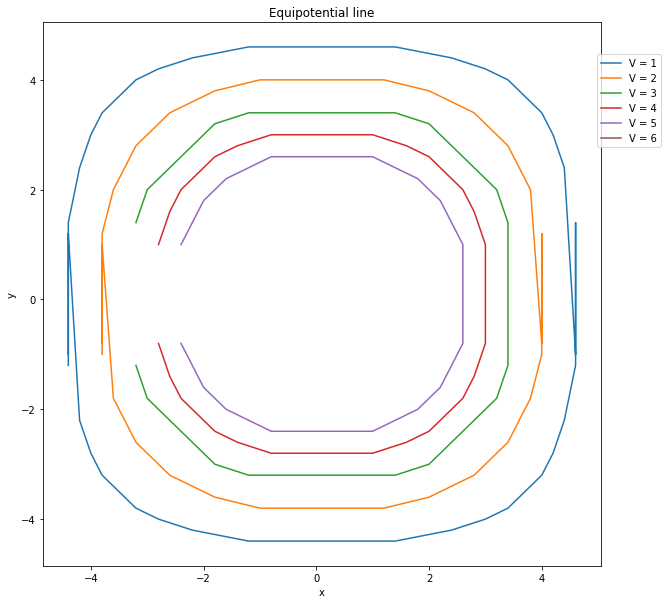

In [51]:
plt.figure(figsize=(10,10))
for k in range(1, 7):
    i_list = []
    j_list = []
    for i in range(len(V[0, :])):
        for j in range(len(V[0, :])):
            if(np.abs(V[i, j] - k) < 0.06):
                i_list.append(i)
                j_list.append(j)
    i_list_new_1 = np.asarray(i_list[::2]) / 5 - 5
    i_list_new_2 = np.asarray(i_list[1::2]) / 5 - 5
    i_list_new = np.concatenate((i_list_new_1, i_list_new_2[::-1]))
    j_list_new_1 = np.asarray(j_list[::2]) / 5 - 5
    j_list_new_2 = np.asarray(j_list[1::2]) / 5 - 5
    j_list_new = np.concatenate((j_list_new_1, j_list_new_2[::-1]))
    plt.plot(i_list_new, j_list_new, label = 'V = {}'.format(k))
plt.title('Equipotential line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper center', bbox_to_anchor=(1.05 ,0.95))
plt.show()

在曲线两段出现了一些奇怪的折线，这是因为我们在取样时对数组处理的并不好，我们忽略这些影响。同时，内部的等势线未闭合，这是取点不足所致。

可以看出，越靠近中央的等势线越接近于一个正多边形，而越靠近外围则越接近于一个正方形。这是由于我们所取的正方形的边界条件所决定的。对于取无穷远点为零势点的解来说，其越远离中心，等势线形状应越趋近于圆形。

**5.8** Extend our treatment of a point charge in a metal box to deal with the case in which the charge is located near one face of the box. Study how the equipotential contours are affected by the proximity of a grounded surface (the face of the box).

# Problem 5.8
对于本题，其满足的偏微分方程变为：

$$\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} + \frac{\partial^2 V}{\partial z^2} = -\frac{\rho}{\epsilon_0}$$

其中$\rho$为电荷密度，$\epsilon_0$为真空介电常数

上式为非齐次偏微分方程。按上述方式处理后，可以得到：

$$V(i,j,k)=\frac{1}{6}[V(i+1,j,k)+V(i-1,j,k)+V(i,j+1,k)+V(i,j-1,k)+V(i,j,k+1)+V(i,j,k-1)] + \frac{\rho(i,j,k)\Delta x^2}{6\epsilon_0}$$

若取某一点处的点电荷为$\rho(i, j, k) = \frac{q}{dx^3}$；取$\frac{q}{\epsilon_0} = 1$，并令其他处电荷密度为0。此时，在计算公式中最后一项变为$\frac{1}{6dx}$。取一边长为2的正方体接地盒，其上电势$V = 0$。记盒子的中心为原点（0,0,0）。我们试图讨论当电荷接近盒子表面时，其解会发生怎么样的变化。我们先把解方程的代码写出来。

我们取$V_0（i,j,k) = 0, \Delta x = \Delta y = \Delta z = 0.1$

In [22]:
def relaxation_3D(V_old, V_new, rho_coor, step = 0.1):
    for i in range(1, len(V_old[1,:,:]) - 1):
        for j in range(1, len(V_old[1,:,:]) - 1):
            for k in range(1, len(V_old[1,:,:]) - 1):
                V_new[i, j, k] = 1 / 6 * (V_old[i + 1, j, k] + V_old[i - 1, j, k] + V_old[i, j + 1, k] + V_old[i, j - 1, k] + V_old[i, j, k + 1] + V_old[i, j, k - 1])
                if((np.asarray([i, j, k]) == rho_coor).all()):
                    V_new[i, j, k] += 1 / (6 * step)

def cal_dV_3D(V_old, V_new):
    return np.abs(V_old - V_new).sum()

class potential(object):
    def __init__(self, i, j, k, step = 0.1, rangee = 2):
        self.i = i
        self.j = j
        self.k = k
        self.step = step
        self.rangee = rangee
        self.V = np.zeros((int(rangee / step), int(rangee / step), int(rangee / step)))
        self.V_sub = self.V.copy()
    
    def relaxing(self):
        m = 0
        coor = np.rint((np.asarray([self.i, self.j, self.k]) + self.rangee / 2) / self.step)
        while(True):
            relaxation_3D(self.V, self.V_sub, coor, self.step)
            relaxation_3D(self.V_sub, self.V, coor, self.step)
            m += 1
            if(m > 1000):
                dV = cal_dV_3D(self.V_sub, self.V)
                if(dV < 1e-8 * (self.rangee / self.step) ** 3):
                    break
    
    def plot_3D(self):
        mlab.clf()
        mlab.volume_slice(self.V)
        mlab.axes(ranges = [-1, 1, -1, 1, -1, 1], xlabel='x', ylabel='y', zlabel='z')
        mlab.outline()
        mlab.colorbar()

In [23]:
A = potential(0.2, 0.6, -0.3)
A.relaxing()
A.plot_3D()

In [88]:
mlab.clf()
mlab.contour3d(A.V, contours = 8)
mlab.axes(ranges = [-1, 1, -1, 1, -1, 1], xlabel='x', ylabel='y', zlabel='z')
mlab.colorbar()

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

对于这一问题，我们取的场源位置为（0.2， 0.6， -0.3），在j方向（3D图中为x方向上）十分接近边界。从而我们猜测在x方向上的场分布受边界影响会很大。

其生成的场在含场源的x-y截面上的整体图如下：
![Potential_field_with_charge_1](./Potential_field_with_charge_1.png)
![Potential_field_with_charge_2](./Potential_field_with_charge_2.png)

是很标准的峰状,其底部为圆形。这是由于场源处的势能值非常大（为2.39，而在下面我们会看到场的电势分布的正常值为1e-2左右），以至于其他的地方的势能几乎无法被显现。但如果我们考虑不含场源的平面，那么边界条件对其的影响十分明显。
![Potential_field_with_charge_3](./Potential_field_with_charge_3.png)
![Potential_field_with_charge_4](./Potential_field_with_charge_4.png)
上面两张图是距离场源距离为0.1的截面势图（此时最大电势降到0.722）。可以看到，在远离边界的区域，其边界接近于圆形；但在接近边界条件的部分，其迅速跌落至0，呈现出于边界形状相似的形状。

如果我们考虑距离更远的截面，那么这种效应会更加明显。下两图为距离场源0.9的截面势图（此时最大电势已经仅有0.0121）：
![Potential_field_with_charge_5](./Potential_field_with_charge_5.png)
![Potential_field_with_charge_6](./Potential_field_with_charge_6.png)

附注：
mayavi的mlab.contour3d()不知道为什么没办法画出图比较正常的图来，画出的图总是对称的，这显然不符合事实。

也许还可以利用势能的导数画出三维空间中的电场的矢量图，但是这里时间有限，也许可以留作之后再画。